In [71]:
%pylab notebook

import pandas as pd
import numpy as np
from datetime import datetime
import lightgbm as gbm

Populating the interactive namespace from numpy and matplotlib


/Users/karper/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [72]:
def score(Y_pred, Y_true):
    E = np.sqrt(np.sum((Y_pred - Y_true)**2))
    L2pred = np.sqrt(np.sum(Y_pred**2))
    L2true = np.sqrt(np.sum(Y_true**2))
    
    return 2*E/(L2pred + L2true)
    

In [346]:
class LGBMReg():
    
    def __init__(self):
        pass
                
    def fit(self,X, Y, T):
        self.output_tags = Y.columns
        self.estimator = {}
        X = X.rolling(5).median()          
        X = X.fillna(method='bfill')
        Y = Y.rolling(5).median()
        Y = Y.fillna(method='bfill')        
        for var in self.output_tags:
            self.estimator[var] = gbm.LGBMRegressor(n_estimators=100)

        TT = pd.to_datetime(T, unit='ms').values
        print('Training on ', TT[0], TT[-1])
        for var in self.output_tags:
            y = Y[var]
            self.estimator[var].fit(X, y)
            
    
    
    def predict(self, X, T):
        Ypred = pd.DataFrame()
        Ypred['timestamp'] = T
        for var in self.output_tags:
            Ypred[var] = self.estimator[var].predict(X.values)
        
        return Ypred
    

In [347]:
def run_scenario(data, input_tags, output_tags, window_size, train_to_time):
    train_condition = (data.timestamp < train_to_time)
    data_train = data[train_condition]
    data_test  = data[~train_condition]

    # Do the initial fit
    X_train = data_train[input_tags]
    Y_train = data_train[output_tags]
    T_train = data_train.timestamp
    
    gbmEst = LGBMReg()
    gbmEst.fit(X_train, Y_train, T_train)
    
    T_test = data_test.timestamp.values
    T = T_test
    DT = T[-1]-T[0]
    if(DT>window_size):
        dt_pred = np.arange(T[0], T[-1], window_size)
    else:
        dt_pred=[T[0]]


    Ypred = pd.DataFrame(columns=output_tags)
        
    for i in range(0, len(dt_pred)):
        t = dt_pred[i]
        t_next = np.minimum(T[-1], t+window_size)
        t_condition = (data_test.timestamp >= t) & (data_test.timestamp < t_next)
        Xpred  = data_test[input_tags]
        Xpred  = Xpred[t_condition]
        if(len(Xpred)<1):
            break
            
        T_this = data_test[t_condition].timestamp
            
        Ypred_this = pd.DataFrame()
        Ypred_this['timestamp'] = T_this
        Ypred_this = gbmEst.predict(Xpred, T_this)
            
        Ypred = pd.concat([Ypred, Ypred_this])
            
        if(t_next==t+window_size):
            Ytrue  = data_test[output_tags]
            Ytrue  = Ytrue[t_condition]
            Y_train = pd.concat([Y_train, Ytrue])
            X_train = pd.concat([X_train, Xpred])
            gbmEst.fit(X_train, Y_train, T_this)
                            
    return Ypred
    
    
    
    
    
    

In [348]:
data = pd.read_csv('../virtual_metering/d2_train.csv')

In [349]:
data = data.drop(['SKAP_18SCSSV3205/BCH/10sSAMP|average', 'SKAP_18HPB320/BCH/10sSAMP|average'], axis=1)

In [350]:
time_cond = (data.timestamp > int(datetime(2014, 3, 1).timestamp()*1000))
data = data[time_cond]

In [351]:
output_columns = ['SKAP_18FI381-VFlLGas/Y/10sSAMP|average',
                  'SKAP_18FI381-VFlLH2O/Y/10sSAMP|average',
                  'SKAP_18FI381-VFlLOil/Y/10sSAMP|average']

output_data = data[output_columns]
input_data  = data.drop(output_columns, axis=1)
input_data  = input_data.drop(['timestamp','Unnamed: 0'], axis=1)
input_columns = list(input_data.columns.values)

In [353]:
wsize = int(1000*60*60*24*14)
rcond = (data.index < len(data)*0.7)
train_to_time = data[rcond].timestamp.values[-1]
Ypred = run_scenario(data, input_columns, output_columns, wsize, train_to_time)

Training on  2014-02-28T23:10:00.000000000 2016-01-19T01:10:00.000000000
Training on  2016-01-19T01:20:00.000000000 2016-02-02T01:10:00.000000000
Training on  2016-02-02T01:20:00.000000000 2016-02-16T01:10:00.000000000
Training on  2016-02-16T01:20:00.000000000 2016-03-01T01:10:00.000000000
Training on  2016-03-01T01:20:00.000000000 2016-03-15T01:10:00.000000000
Training on  2016-03-15T01:20:00.000000000 2016-03-29T01:10:00.000000000
Training on  2016-03-29T01:20:00.000000000 2016-04-12T01:10:00.000000000
Training on  2016-04-12T01:20:00.000000000 2016-04-26T01:10:00.000000000
Training on  2016-04-26T01:20:00.000000000 2016-05-10T01:10:00.000000000
Training on  2016-05-10T01:20:00.000000000 2016-05-23T21:40:00.000000000
Training on  2016-05-24T12:20:00.000000000 2016-06-07T01:10:00.000000000
Training on  2016-06-07T01:20:00.000000000 2016-06-20T22:50:00.000000000
Training on  2016-06-22T19:40:00.000000000 2016-07-03T20:10:00.000000000
Training on  2016-07-05T19:40:00.000000000 2016-07-

In [356]:
data_test = data[~rcond]
Y_test = data_test[output_columns]
for var in output_columns:
    print(var, score(Ypred[var], Y_test[var]))

SKAP_18FI381-VFlLGas/Y/10sSAMP|average 0.057657856276629414
SKAP_18FI381-VFlLH2O/Y/10sSAMP|average 0.2024775965475829
SKAP_18FI381-VFlLOil/Y/10sSAMP|average 0.20111473435910268


<IPython.core.display.Javascript object>


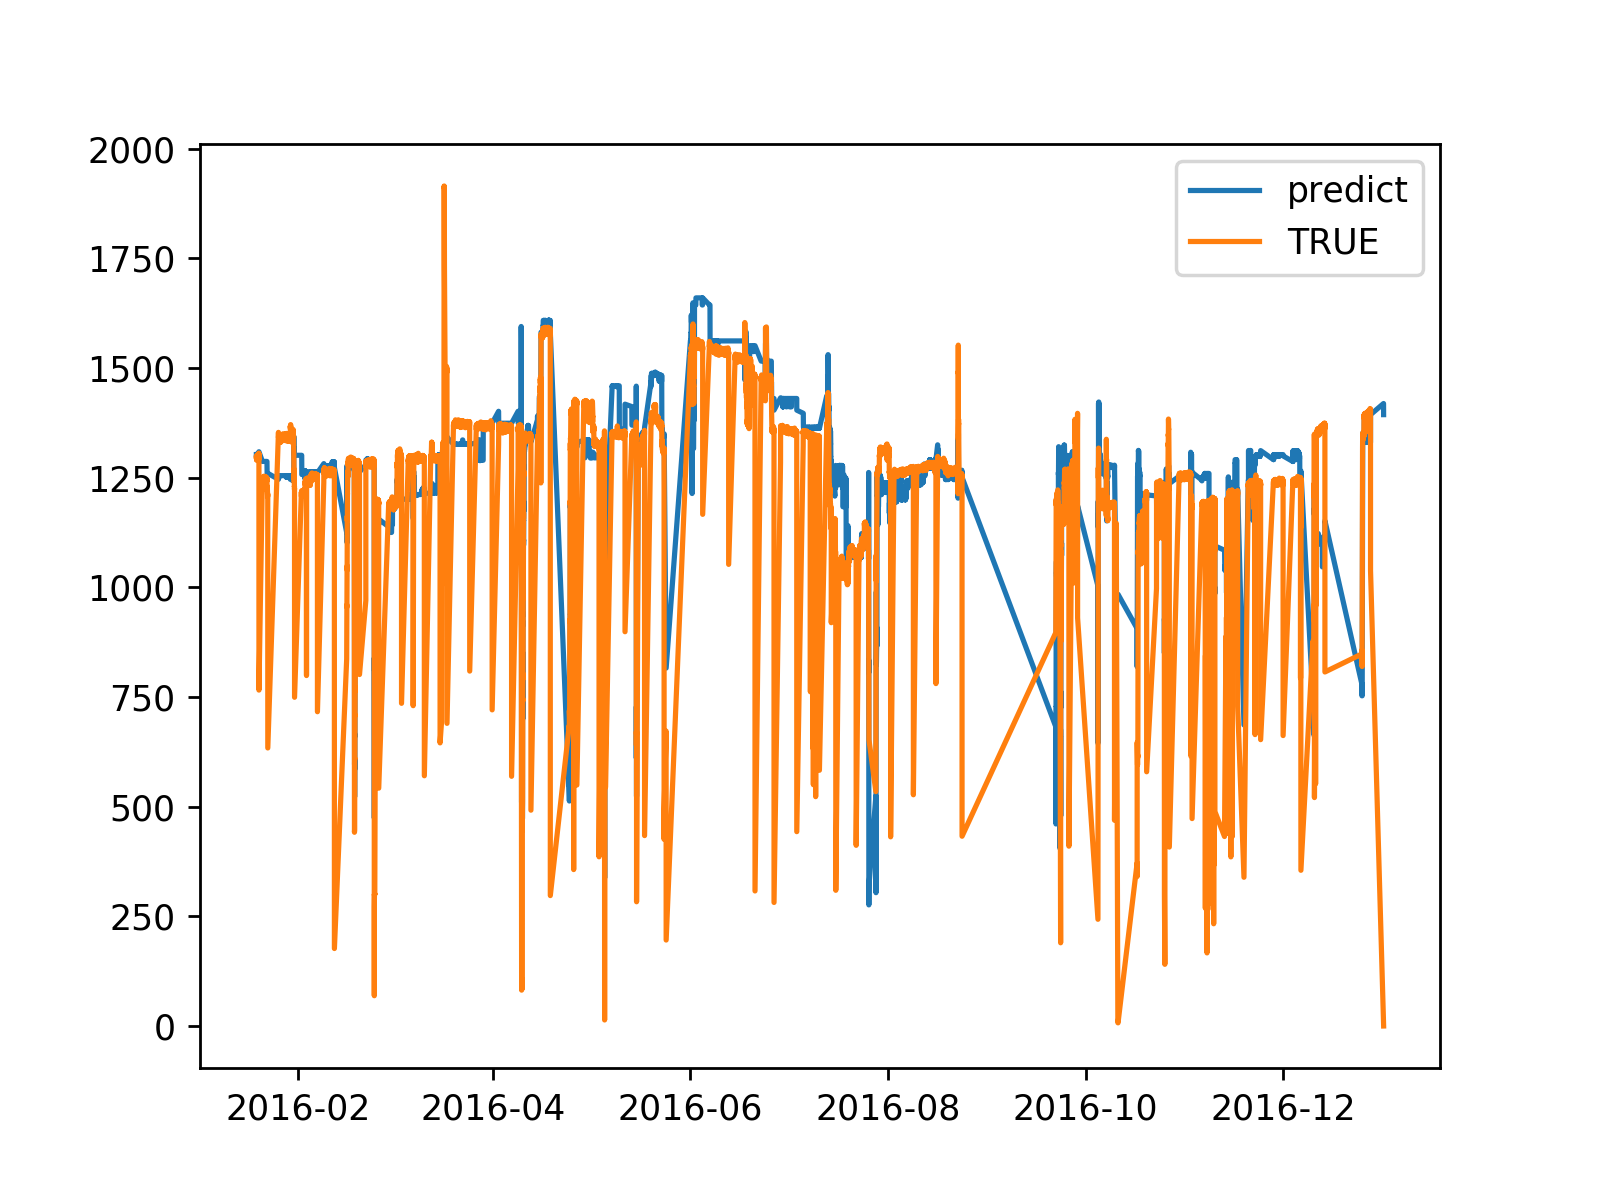

<IPython.core.display.Javascript object>


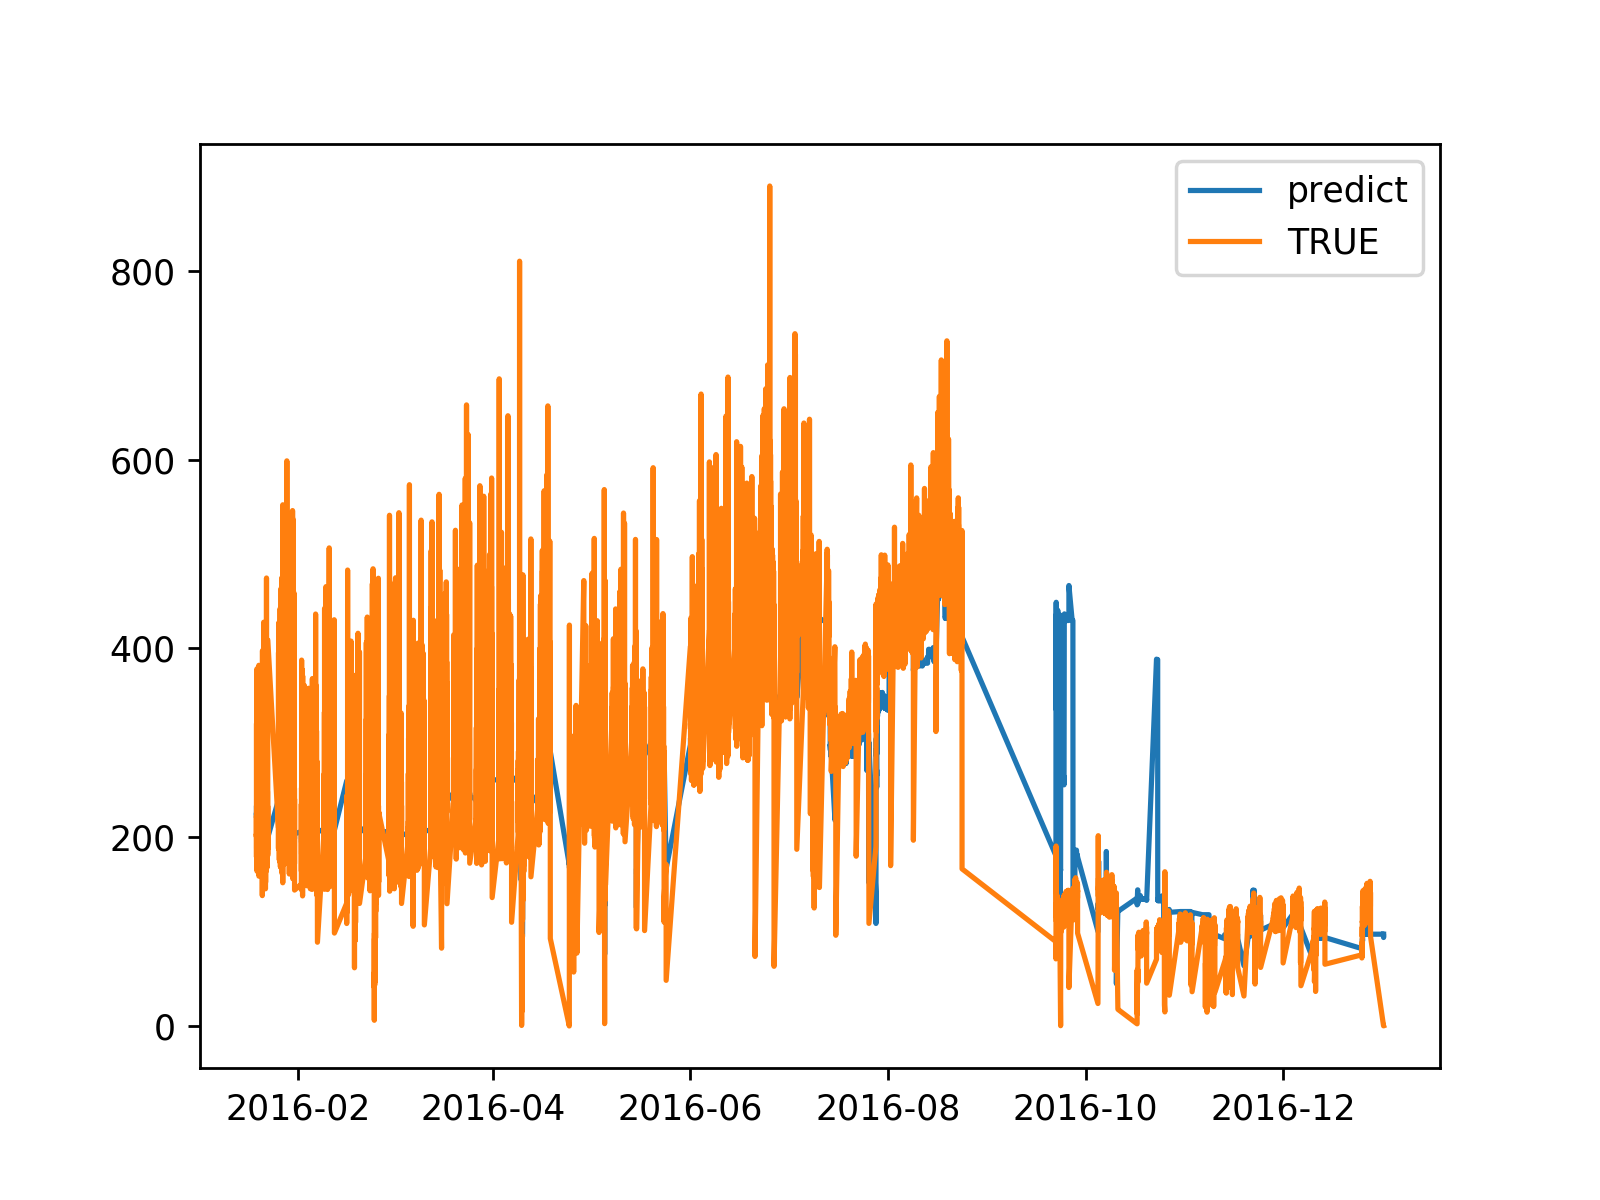

<IPython.core.display.Javascript object>


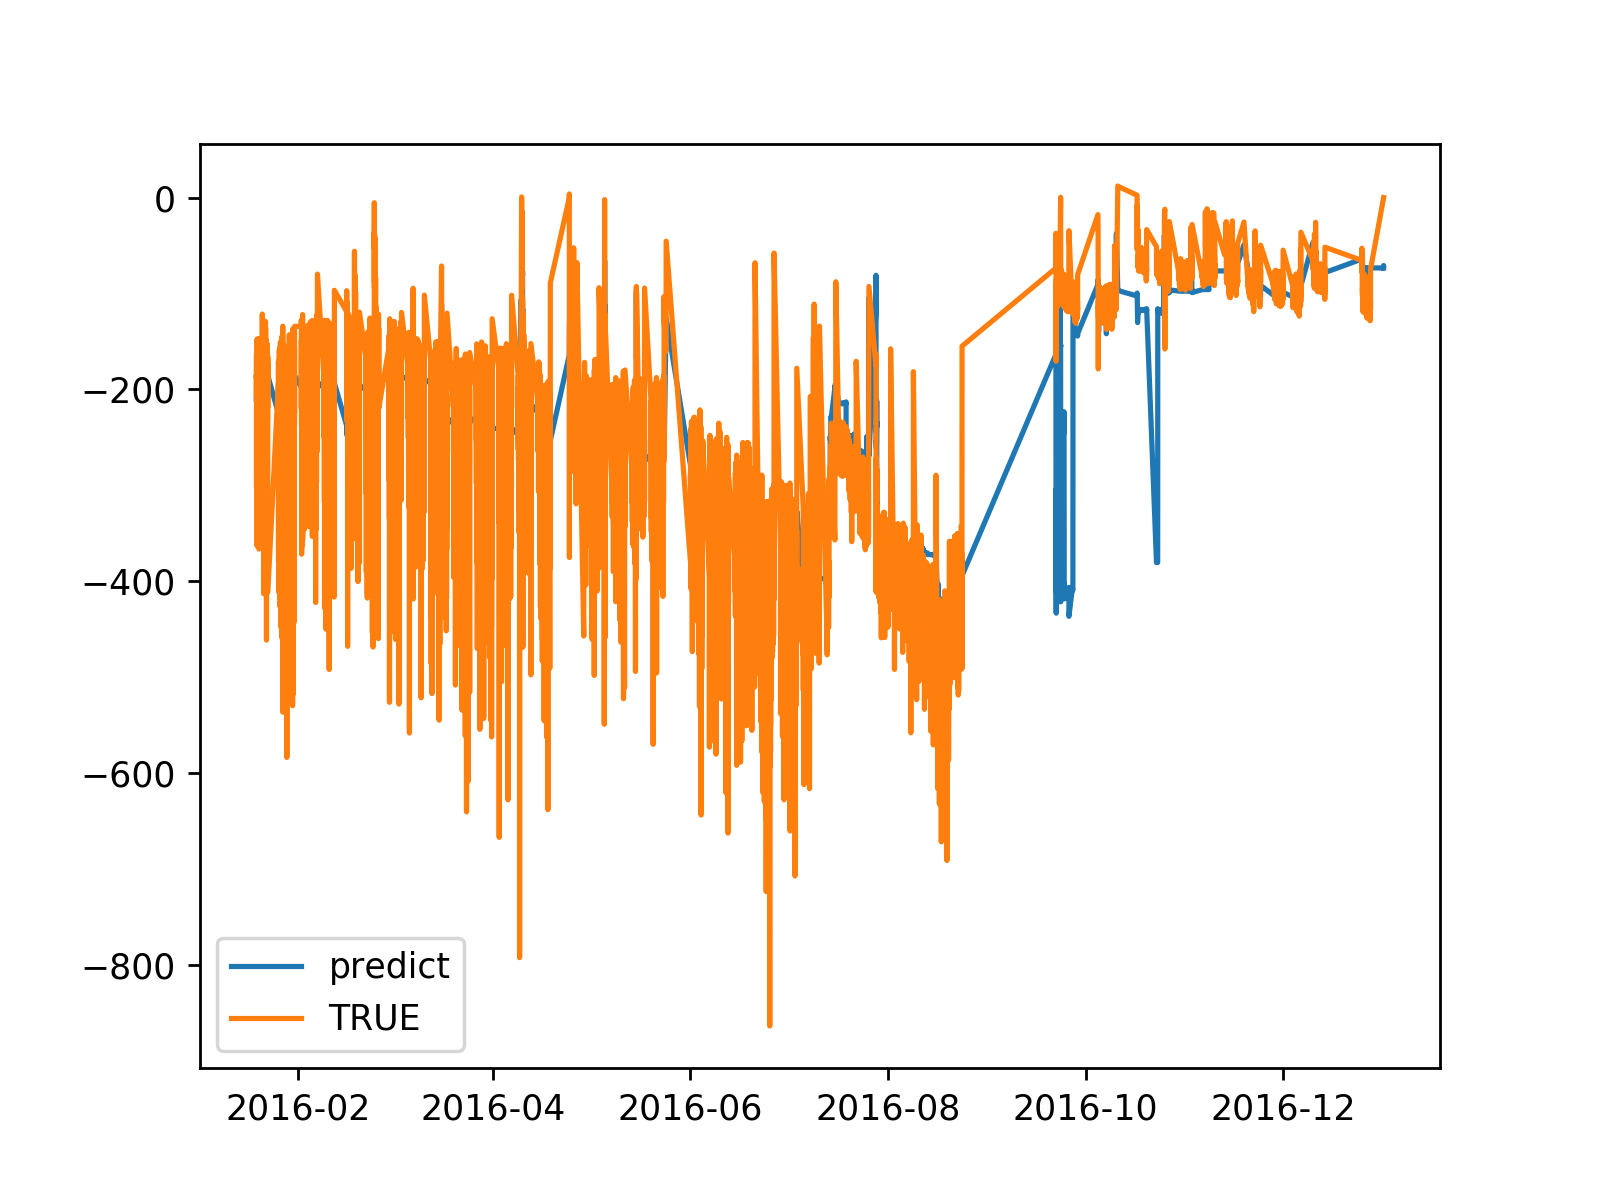

In [357]:
T_pred = pd.to_datetime(Y_pred.timestamp, unit='ms')
T_test = pd.to_datetime(data_test.timestamp, unit='ms')


for var in output_columns:
    plt.figure()
    plt.plot(T_pred, Y_pred[var], label='predict')
    plt.plot(T_test, Y_test[var], label='TRUE')
    plt.legend()